In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
X = np.load('x_digits.npy')
Y = np.load('y_digits.npy')

In [3]:
X[0].shape, Y.shape

((129, 71), (35631,))

There are 35 thousand 'pictures' (observations) representing numbers from 0 to 9. Each number has 129 rows with 71 columns. (maybe, maybe not, check again)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape([-1, 129, 71, 1])
X_test = X_test.reshape([-1, 129, 71, 1])


We split the data in train and test sets as we will use the built-in split from tensorflow when training the neural network.

In [5]:
X_train[1].shape

(129, 71, 1)

### Take 1:
We start of with a small neural network, keeping the size of the feature maps relavtively small. As advised we use the ReLu activation function. The size of the feature map is 3 x 3. We also use EarlyStopping callback and Learning Rate callback.

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(X_train[0].shape))
model.add(tf.keras.layers.Conv2D(8, (3,3), activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

EarlyStoppingCB = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = "True")
LearningRateCB = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 2)

optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001, weight_decay = 0.002)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(X_train, Y_train, epochs = 30, validation_split=0.2, callbacks = [EarlyStoppingCB, LearningRateCB])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.1400 - loss: 3.1947 - val_accuracy: 0.2510 - val_loss: 1.9091 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3351 - loss: 1.7517 - val_accuracy: 0.6904 - val_loss: 0.9012 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7465 - loss: 0.7481 - val_accuracy: 0.8223 - val_loss: 0.5392 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8577 - loss: 0.4218 - val_accuracy: 0.8720 - val_loss: 0.3843 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9089 - loss: 0.2721 - val_accuracy: 0.8995 - val_loss: 0.3058 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9381 - loss: 0.1886 - val_accuracy: 0.9035 - val_loss: 0.2971 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9531 - l

In [10]:
single_example = X_test[0]  # Example, take the first sample from the test set
single_example = single_example.reshape(129, 71, 1)  # Reshape to (129, 71, 1)

# Expand dimensions to make it a batch of size 1 (shape becomes (1, 129, 71, 1))
single_example = np.expand_dims(single_example, axis=0)

# Make a prediction
prediction = model.predict(single_example)

# Print the prediction (depending on your output layer, this could be probabilities or class labels)
prediction, Y_test[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


(array([[3.4356715e-17, 1.2530337e-07, 2.4519258e-12, 1.8482159e-10,
         3.2657042e-07, 9.9960572e-01, 5.1621953e-07, 3.9195173e-04,
         1.2881912e-06, 7.9463618e-08]], dtype=float32),
 5.0)

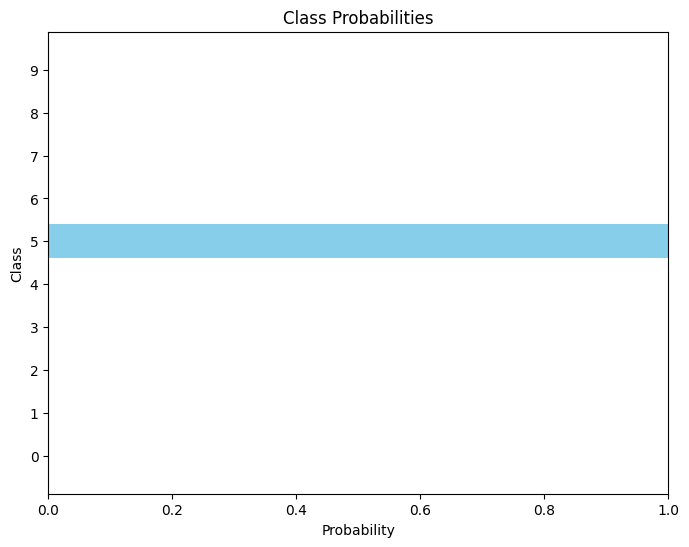

In [15]:
classes = np.arange(10)

probabilities = prediction.flatten()
# Create a horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(classes, probabilities, color='skyblue')
plt.yticks(classes)
plt.xlabel('Probability')
plt.ylabel('Class')
plt.title('Class Probabilities')
plt.xlim(0, 1)  # Since it's a probability, we limit the x-axis to [0, 1]

# Show the plot
plt.show()

In [18]:
from collections import Counter

threshold = 0.5

# Dictionary to count how often each digit is predicted with low confidence
struggling_digits = Counter()

struggling_pairs = Counter()

# Iterate through predictions and corresponding true labels
for probs, true_label in zip(model.predict(X_train), Y_train):
    predicted_label = np.argmax(probs)  # Get the predicted class (class with highest probability)
    max_prob = np.max(probs)  # Get the highest probability

    # If the model is uncertain or if the prediction is incorrect
    if max_prob < threshold or predicted_label != true_label:
        struggling_pairs[(true_label, predicted_label)] += 1  # Count the true-predicted pair

# Output the struggling digit pairs (true label, predicted label)
print("Struggling digit pairs (True Label, Predicted Label):", struggling_pairs)

891/891 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Struggling digit pairs (True Label, Predicted Label): Counter({(9.0, 1): 36, (5.0, 9): 34, (9.0, 5): 22, (5.0, 1): 21, (4.0, 1): 20, (0.0, 2): 19, (3.0, 8): 19, (6.0, 8): 17, (8.0, 6): 17, (2.0, 7): 15, (2.0, 0): 15, (1.0, 9): 14, (8.0, 3): 14, (1.0, 4): 14, (2.0, 8): 14, (5.0, 4): 13, (7.0, 2): 12, (8.0, 2): 12, (2.0, 3): 12, (0.0, 7): 11, (2.0, 4): 11, (9.0, 9): 11, (5.0, 5): 11, (2.0, 2): 11, (3.0, 2): 10, (3.0, 3): 10, (4.0, 2): 9, (4.0, 4): 9, (1.0, 5): 9, (7.0, 7): 9, (7.0, 5): 9, (6.0, 6): 8, (6.0, 7): 8, (0.0, 4): 8, (0.0, 0): 8, (6.0, 3): 7, (3.0, 6): 7, (8.0, 1): 7, (9.0, 3): 7, (7.0, 8): 7, (3.0, 9): 6, (9.0, 2): 6, (0.0, 6): 6, (1.0, 1): 6, (4.0, 5): 6, (8.0, 4): 5, (8.0, 5): 5, (0.0, 3): 5, (3.0, 5): 5, (6.0, 0): 5, (6.0, 5): 5, (8.0, 8): 4, (3.0, 7): 4, (9.0, 0): 4, (4.0, 0): 4, (6.0, 1): 4, (7.0, 6): 4, (0.0, 9): 4, (1.0, 2): 4, (6.0, 4): 3, (1.0, 8): 3, (7.0, 9): 3, (7.0, 4): 3, (7.0, 1): 3, (3.0, 0): 3, (8.0, 9): 3, (4.0, 7): 3,

In [22]:
predictions = model.predict(X_train)

891/891 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


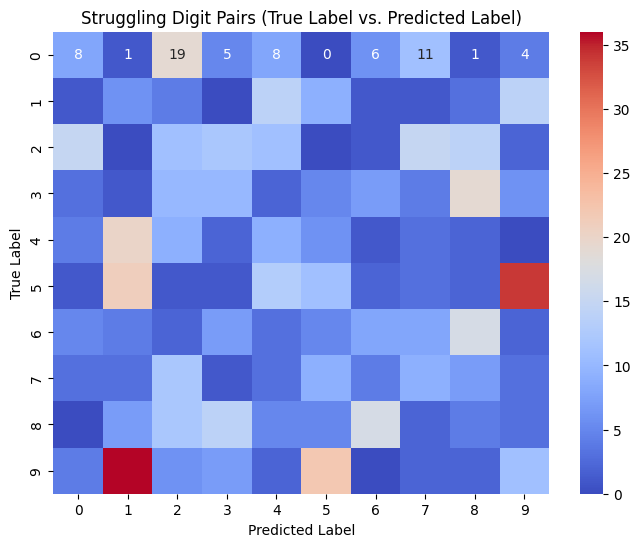

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

threshold = 0.5

# Dictionary to count the struggling pairs (true_label, predicted_label)
struggling_pairs = Counter()

# Iterate through predictions and corresponding true labels
for probs, true_label in zip(predictions, Y_train):
    predicted_label = np.argmax(probs)  # Get the predicted class (class with highest probability)
    max_prob = np.max(probs)  # Get the highest probability
    # If the model is uncertain or if the prediction is incorrect
    if max_prob < threshold or predicted_label != true_label:
        struggling_pairs[(int(true_label), int(predicted_label))] += 1  # Count the true-predicted pair

# Initialize a confusion matrix (10x10 since we have digits 0-9)
confusion_matrix = np.zeros((10, 10))

# Populate the confusion matrix with the struggling pairs
for (true_label, predicted_label), count in struggling_pairs.items():
    confusion_matrix[true_label, predicted_label] = count

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='coolwarm', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Struggling Digit Pairs (True Label vs. Predicted Label)')
plt.show()

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(X_train[0].shape))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

EarlyStoppingCB = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = "True")
LearningRateCB = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 1)

optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001, weight_decay = 0.005)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(X_train, Y_train, epochs = 30, validation_split=0.2, callbacks = [EarlyStoppingCB, LearningRateCB])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 148s 202ms/step - accuracy: 0.4459 - loss: 3.3447 - val_accuracy: 0.9026 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 142s 198ms/step - accuracy: 0.9179 - loss: 0.2596 - val_accuracy: 0.9176 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 145s 203ms/step - accuracy: 0.9513 - loss: 0.1504 - val_accuracy: 0.9354 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 150s 211ms/step - accuracy: 0.9630 - loss: 0.1121 - val_accuracy: 0.9279 - val_loss: 0.2077 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 144s 202ms/step - accuracy: 0.9828 - loss: 0.0533 - val_accuracy: 0.9472 - val_loss: 0.1909 - learning_rate: 5.0000e-04
Epoch 6/30
185/713 ━━━━━━━━━━━━━━━━━━━━ 1:40 190ms/step - accuracy: 0.9898 - loss: 0.0329

KeyboardInterrupt: 

In [33]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = [129, 71]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler= tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 2)
history = model.fit(X_train, Y_train, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_cb, lr_scheduler])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2751 - loss: 6.7857 - val_accuracy: 0.3643 - val_loss: 2.3307 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4323 - loss: 2.0958 - val_accuracy: 0.5243 - val_loss: 1.6699 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5302 - loss: 1.6069 - val_accuracy: 0.5185 - val_loss: 1.6058 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5681 - loss: 1.4307 - val_accuracy: 0.6060 - val_loss: 1.3237 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6070 - loss: 1.2590 - val_accuracy: 0.5980 - val_loss: 1.2620 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6384 - loss: 1.1299 - val_accuracy: 0.6201 - val_loss: 1.2541 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6465 - loss: 1.1671 - 

Well this works okay, the validation accuracy is not perfect, but it's satisfying. Let's try with swish activation function.

In [34]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = [129, 71]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = "swish", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation = "swish", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation = "swish", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler= tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 2)
history = model.fit(X_train, Y_train, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_cb, lr_scheduler])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2560 - loss: 5.7668 - val_accuracy: 0.4313 - val_loss: 2.0350 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4197 - loss: 2.0398 - val_accuracy: 0.4654 - val_loss: 1.7794 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5057 - loss: 1.6367 - val_accuracy: 0.5590 - val_loss: 1.4783 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5581 - loss: 1.3812 - val_accuracy: 0.5424 - val_loss: 1.4503 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5839 - loss: 1.2322 - val_accuracy: 0.6027 - val_loss: 1.1591 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6182 - loss: 1.1189 - val_accuracy: 0.6308 - val_loss: 1.0953 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6409 - loss: 1.0729 - 

Okay so changing to swish activation function doesn't change anything. Let's move back to the ReLu and increase the number of neurons.

In [35]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = [129, 71]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(400, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(300, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(200, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler= tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 2)
history = model.fit(X_train, Y_train, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_cb, lr_scheduler])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.3111 - loss: 10.0604 - val_accuracy: 0.5034 - val_loss: 1.7093 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5414 - loss: 1.7691 - val_accuracy: 0.6476 - val_loss: 1.2296 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6448 - loss: 1.2819 - val_accuracy: 0.6769 - val_loss: 1.2401 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6993 - loss: 1.0510 - val_accuracy: 0.7043 - val_loss: 1.0639 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7346 - loss: 0.8924 - val_accuracy: 0.7179 - val_loss: 0.9688 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7602 - loss: 0.8421 - val_accuracy: 0.7485 - val_loss: 0.8364 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7875 - 

Nice! The train accuracy reached a whopping 97%, unfortunately, the validation accuracy is 10 percent points less, which is an unacceptable proof of overfitting. Therefore, we will try to change the optimizer to AdamW to introduce weight_decay and regularization. Let's start with weight decay = 0.0075

In [36]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = [129, 71]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(400, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(300, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(200, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001, weight_decay=0.0075)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler= tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 2)
history = model.fit(X_train, Y_train, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_cb, lr_scheduler])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.2981 - loss: 10.5311 - val_accuracy: 0.5232 - val_loss: 1.6547 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5555 - loss: 1.6789 - val_accuracy: 0.6078 - val_loss: 1.2272 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6543 - loss: 1.1291 - val_accuracy: 0.6881 - val_loss: 0.9643 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7051 - loss: 0.9096 - val_accuracy: 0.7465 - val_loss: 0.7937 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7320 - loss: 0.8024 - val_accuracy: 0.7374 - val_loss: 0.8175 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7706 - loss: 0.6918 - val_accuracy: 0.7362 - val_loss: 0.8411 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8288 - 

Hmm that doesn't seem like a lot of help, let's try reducing the number of neurons and add more layers... but that will come in the next episode!